![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


In [ ]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
#Codificar variables booleanas
data['M_Camry'] = data['M_Camry'].astype(int)
data['M_Camry4dr'] = data['M_Camry4dr'].astype(int)
data['M_CamryBase'] = data['M_CamryBase'].astype(int)
data['M_CamryL'] = data['M_CamryL'].astype(int)
data['M_CamryLE'] = data['M_CamryLE'].astype(int)
data['M_CamrySE'] = data['M_CamrySE'].astype(int)
data['M_CamryXLE'] = data['M_CamryXLE'].astype(int)
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [ ]:
data.shape

(10495, 10)

In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape

(7031, 9)

In [ ]:
X_test.shape

(3464, 9)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [ ]:
# Definición de la función que calcula el error cuadrático medio como medida de impureza
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean()) ** 2)

In [ ]:
# Definición de la función para calcular la impureza de una división
def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    mse_total = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)

    mse_impurity_ = mse_total - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)

    return mse_impurity_

In [ ]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):

    features = range(X.shape[1])

    best_split = [0, 0, 0]  # j, split, gain

    # Calcula el MSE antes de cualquier división
    mse_before_split = mse(y)

    # Para todas las varibles
    for j in features:

        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            mse_impurity_ = mse_impurity(X.iloc[:, j], y, split)
            gain = mse_before_split - mse_impurity_

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

In [ ]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()

    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None and level >= max_depth:
        return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

In [ ]:
!pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 48.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2


In [ ]:
# Aplicación de la función tree_grow
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 14508.073389276064,
 'level': 0,
 'split': [6, 1.0],
 'n_samples': 7031,
 'gain': 15420043.819350727,
 'sl': {'y_pred': 14471.201980568012,
  'level': 1,
  'split': [8, 1.0],
  'n_samples': 5352,
  'gain': 15586139.082188237,
  'sl': {'y_pred': 14067.977427131273,
   'level': 2,
   'split': [1, 18007.090909090908],
   'n_samples': 4563,
   'gain': 13549675.89908255,
   'sl': {'y_pred': 18576.89156626506,
    'level': 3,
    'split': -1,
    'n_samples': 415,
    'gain': 5054446.490306948},
   'sr': {'y_pred': 13616.868611378977,
    'level': 3,
    'split': -1,
    'n_samples': 4148,
    'gain': 14251598.190003673}},
  'sr': {'y_pred': 16803.15842839037,
   'level': 2,
   'split': [1, 11953.363636363638],
   'n_samples': 789,
   'gain': 13140749.737482904,
   'sl': {'y_pred': 21752.222222222223,
    'level': 3,
    'split': -1,
    'n_samples': 72,
    'gain': 9540723.896530494},
   'sr': {'y_pred': 16306.181311018132,
    'level': 3,
    'split': -1,
    'n_samples': 717,
 

In [ ]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree):
    predicted = np.zeros(X.shape[0])  # Inicializa un arreglo para las predicciones

    # Si es un nodo hoja, retorna el valor predicho para todas las instancias
    if tree['split'] == -1:
        predicted[:] = tree['y_pred']
    else:
        # Identifica el criterio de división
        j, split = tree['split']
        filter_l = X.iloc[:, j] < split  # Instancias que van al nodo hijo izquierdo
        filter_r = ~filter_l  # Instancias que van al nodo hijo derecho
        X_l, X_r = X.loc[filter_l], X.loc[filter_r]

        # Recursivamente predice para cada partición
        if X_l.shape[0] > 0:  # Si hay instancias que van al nodo hijo izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        if X_r.shape[0] > 0:  # Si hay instancias que van al nodo hijo derecho
            predicted[filter_r] = tree_predict(X_r, tree['sr'])

    return predicted

In [ ]:
# Ejecución de función tree_predict
y_pred = tree_predict(X_test, tree)
y_pred

array([13888.48233598, 13616.86861138, 13616.86861138, ...,
       13616.86861138, 13616.86861138, 16306.18131102])

In [ ]:
# Calculamos el RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculamos el MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 3493.7415606484115
MAE: 2812.610387461701


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2

# Concatenar y_train y X_train
train = pd.concat([y_train, X_train], axis=1)
train.head()


,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,18495,2014,39988,0,0,0,0,0,1,0
333638,10891,2007,38904,0,0,0,0,1,0,0
234716,18994,2016,29607,0,0,0,0,0,1,0
208752,13691,2014,50756,0,0,0,0,0,1,0
348892,19999,2017,10506,0,0,0,0,0,1,0


In [ ]:
train.shape

(7031, 10)

In [ ]:
# Concatena y_test y X_test
test = pd.concat([y_test, X_test], axis=1)

test.shape

(3464, 10)

In [ ]:
test.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
257343,9900,2012,62048,0,0,0,0,1,0,0
326011,6987,2005,111565,0,1,0,0,0,0,0
242354,15814,2014,24203,0,0,0,0,0,1,0
266376,17997,2015,30475,0,0,0,0,0,0,1
396954,18938,2014,30498,0,0,0,0,0,0,1


In [ ]:
# Creación de 10 muestras de bootstrap
np.random.seed(123)

n_samples = train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [ ]:
n_samples

7031

In [ ]:
# Visualización muestra boostrap #1 para entremiento
train.iloc[samples[0], :]

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,17881,2016,40999,0,0,0,0,0,1,0
171999,14990,2014,52527,0,0,0,0,0,1,0
304172,8995,2009,123202,0,1,0,0,0,0,0
74828,14500,2015,38807,0,0,0,0,0,1,0
192974,9995,2005,51260,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
134843,14555,2014,22221,0,0,0,0,1,0,0
325075,12991,2013,86593,0,0,0,0,0,1,0
61213,16997,2014,28044,0,0,0,0,0,1,0
181222,15949,2016,49368,0,0,0,0,0,0,1


In [ ]:
# Construcción un árbol de decisión para cada muestra boostrap


# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)

y_pred


,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [ ]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2136.3519863123465
Árbol  2 tiene un error:  2122.718759132052
Árbol  3 tiene un error:  2087.278992468617
Árbol  4 tiene un error:  2168.518742842026
Árbol  5 tiene un error:  2113.8811455834793
Árbol  6 tiene un error:  2127.933470769012
Árbol  7 tiene un error:  2184.414847251443
Árbol  8 tiene un error:  2138.1071697514985
Árbol  9 tiene un error:  2132.097520859104


In [ ]:
# Predicciones promedio para cada observación del set de test
y_pred.mean(axis=1)

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: object

In [ ]:
# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

1796.4355868399332

In [ ]:

mae = mean_absolute_error(y_test, y_pred.mean(axis=1))
mae

1340.0160739030025

Los resultados muestran que el método de bagging manual ha mejorado significativamente la precisión de las predicciones en comparación con el método de árbol de decisión manual, el RMSE pasó de 3493.7 a 1796.4, y el Mae pasó de 2812.6 a 1340.0. Esta mejora en la precisión se da por que el método bagging reduce la variabilidad o varianza, la cual es muy alta para arboles de decisión. Al incluir las muestras aleatorias para la creación de árboles se reduce la varianza, lo que lleva a predicciones más estables y precisas.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3

n_features = X_train.shape[1]
max_features = int(np.log(n_features))

from sklearn.ensemble import BaggingRegressor

bagreg = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=max_features),
                          n_estimators=10, bootstrap=True, oob_score=True, random_state=1)



In [ ]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([13649. ,  6240.2, 16492. , ..., 20000. , 11184.8, 11986. ])

In [ ]:
# Calculamos el RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculamos el MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 1891.6278473685522
MAE: 1408.1009202654222


Los resultados muestran que, en este caso particular, el modelo de bagging que se creó manualmente ha producido resultados ligeramente mejores en comparación con el modelo de bagging creado con la biblioteca sklearn. Sin embargo, la diferencia en los resultados es pequeña y podría depender de factores como la selección de hiperparámetros y la aleatoriedad inherente en los métodos de bagging.

Para este caso se uso el mismo número de árboles (10), y se tuvo un cambio al limitar el numero de características consideradas en cada división de nodo durante la construcción de los árboles de decisión, esta decisión puede ayudar a mejorar la eficiencia computacional y como vimos, no genera un resultado muy diferente al modelo anterior donde no se limitaba, por lo que es una muy buena opción a considerar.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4

# Definir el modelo de Random Forest
rf_regressor = RandomForestRegressor(n_estimators=100,  # Número de árboles en el bosque
                                      max_depth=None,  # Profundidad máxima de cada árbol (None para ilimitada)
                                      min_samples_split=2,  # Número mínimo de muestras requeridas para dividir un nodo interno
                                      min_samples_leaf=1,  # Número mínimo de muestras requeridas para estar en un nodo hoja
                                      max_features='auto',  # Número de características a considerar en cada división ('auto' = todas)
                                      random_state=1)  # Semilla aleatoria para reproducibilidad


In [ ]:

# Calcula el error cuadrático medio negativo utilizando cross_val_score
# La métrica utilizada será el MSE (negativo)
cross_val_results = cross_val_score(rf_regressor, X, y, cv=10, scoring='neg_mean_squared_error')

# Convierte los resultados a positivos y calcula la raíz cuadrada para obtener el MSE
mse_scores = -cross_val_results  # Cambiamos el signo para obtener valores positivos
mse_scores_sqrt = np.sqrt(mse_scores)  # Calculamos la raíz cuadrada para obtener el MSE

# Muestra los resultados
print("MSE Scores:", mse_scores)
print("RMSE Scores:", mse_scores_sqrt)
print("Mean RMSE:", np.mean(mse_scores_sqrt))



MSE Scores: [3253004.42441917 2878200.41481769 2987772.5582618  3300101.72860831
 3098297.64852341 2864723.10089133 2861767.43394989 2886714.32283258
 3177251.41967456 3212625.09311121]
RMSE Scores: [1803.60872265 1696.52598413 1728.51744517 1816.61821212 1760.19818444
 1692.54929054 1691.67592462 1699.03334954 1782.48461976 1792.37972905]
Mean RMSE: 1746.3591462016204


En este caso usamos el cross_val_score con scoring='neg_mean_squared_error' para calcular el error cuadrático medio negativo (negativo porque sklearn espera que mayores valores sean mejores, pero queremos minimizar el MSE, que es mejor cuanto más pequeño sea).

El resultado nos da un RMSE de 1746.3, el cual es menor que los metodos anteriormente utilizados.




### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

**Calibración de n_estimators **


In [ ]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(1, 100, 5)

# Definición de lista para almacenar el RMSE promedio para cada valor de n_estimators
rmse_scores = []


# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf_regressor = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    # Calcular el negativo del RMSE para utilizar en cross_val_score
    # (scikit-learn espera que mayores valores sean mejores)
    neg_rmse = -cross_val_score(rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
    # Calcular la raíz cuadrada para obtener el RMSE
    rmse_scores.append(np.sqrt(np.mean(neg_rmse)))


Text(0, 0.5, 'RMSE')

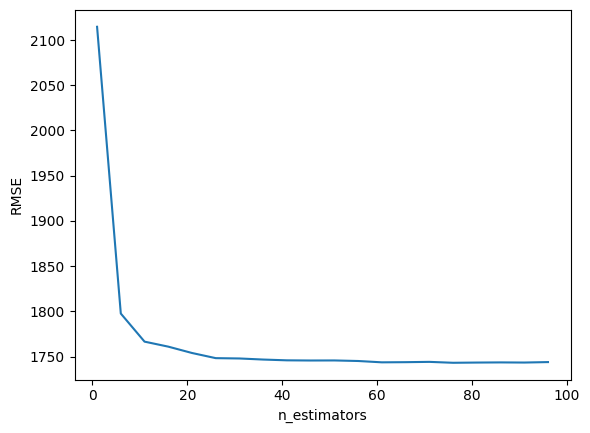

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators

plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [ ]:
# Encuentra el índice del valor mínimo en la lista de RMSE
best_index = np.argmin(rmse_scores)
# Obtiene el valor de n_estimators correspondiente al índice del mínimo RMSE
best_n_estimators = estimator_range[best_index]
print("El mejor valor de n_estimators es:", best_n_estimators)


El mejor valor de n_estimators es: 76


**Calibracióm max_features**

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X_train.columns)+1)

# Definición de lista para almacenar el RMSE promedio para cada valor de n_estimators
rmse_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for feature in feature_range:
    rf_regressor = RandomForestRegressor(n_estimators=41, max_features=feature, random_state=1, n_jobs=-1)
    # Calcular el negativo del RMSE para utilizar en cross_val_score
    # (scikit-learn espera que mayores valores sean mejores)
    neg_rmse = -cross_val_score(rf_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
    # Calcular la raíz cuadrada para obtener el RMSE
    rmse_scores.append(np.sqrt(np.mean(neg_rmse)))

9

Text(0, 0.5, 'RMSE')

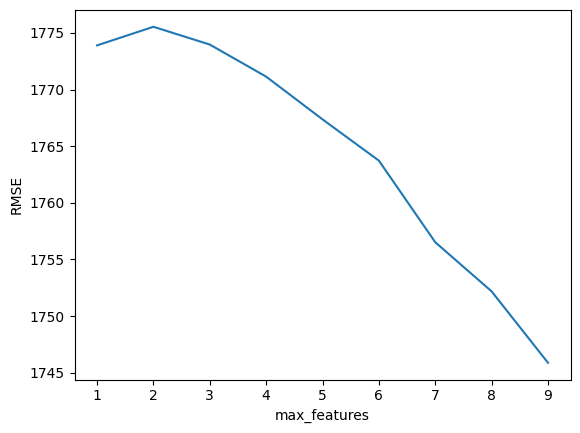

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')

**Implementación de un Random Forest con los mejores parámetros**

In [ ]:
# Definición del modelo con los parámetros max_features=9 y n_estimators=41
rf_regressor = RandomForestRegressor(n_estimators=41, max_features=9, random_state=1, n_jobs=-1)
rf_regressor.fit(X, y)

RandomForestRegressor(max_features=9, n_estimators=41, n_jobs=-1,
                      random_state=1)

In [ ]:
feature_cols = X_train.columns
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [ ]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':feature_cols, 'importance':rf_regressor.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000461
3,M_Camry4dr,0.001106
5,M_CamryL,0.001172
7,M_CamrySE,0.004861
2,M_Camry,0.006118
6,M_CamryLE,0.009856
8,M_CamryXLE,0.014620
1,Mileage,0.256070
0,Year,0.705736


In [ ]:
# Encuentra el índice del valor mínimo en la lista de RMSE
best_index = np.argmin(rmse_scores)
# Obtiene el valor correspondiente al índice del mínimo RMSE
best_feauture = feature_range[best_index]
print("El mejor valor de feature es:", best_feauture)

El mejor valor de feature es: 9


In [ ]:
min_rmse=min(rmse_scores)
min_rmse

1745.8744975801558

Después de realizar la validación de parámetros, se encontró que los parámetros que minimizan el error cuadrático medio son 9 características y 41 estimadores, lo que resulta en un RMSE de 1745.8, este es un mejor resultado que los modelos analizados previamente.

Si comparamos con el modelo de random forest inicial, la diferencia se presenta en el numero de estimadores, ya que en el modelo inicial se usaron 100 y al optimizar este parametro se encontro un mejor resultado al usar solo 41 estimadores, lo que adicionalmente mejora la eficiencia computacional.
En cuanto al numero de caracteristicas, en ambos modelos se usaron todas las caracteristas, lo cual no representó un cambio.



### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

xgb_regressor = XGBRegressor(random_state=1)

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse_xboost = np.sqrt(mse)
print("RMSE:", rmse_xboost)

RMSE: 1605.2355199928948


Comparando los tres modelos, el modelo XGBoost parece tener el mejor desempeño en términos del RMSE, con un promedio de alrededor de 1605.23, seguido por el modelo de Random Forest y luego el de Bagging. Esto sugiere que XGBoost está produciendo predicciones más precisas en comparación con los otros dos modelos, el cual podria mejorar con una calibracion.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],  # Tasa de aprendizaje
    'gamma': [0, 0.1, 0.3],  # Parámetro de regularización gamma
    'colsample_bytree': [0.6, 0.8, 1.0]  # Proporción de características a considerar al construir cada árbol
}

# Creamos una instancia del modelo XGBoost Regressor
xgb_regressor = XGBRegressor(random_state=1)

# Configuramos la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ejecutamos la búsqueda de hiperparámetros en los datos
grid_search.fit(X_train, y_train)

# Obtenemos los mejores parámetros encontrados
best_params = grid_search.best_params_

best_xgb_regressor = XGBRegressor(**best_params, random_state=1)

best_xgb_regressor.fit(X_train, y_train)

y_pred = best_xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse_calibrado = np.sqrt(mse)
print("RMSE:", rmse_calibrado)


RMSE: 1556.9694822864976


Los beneficios de utilizar learning_rate son que controla la velocidad de aprendizaje del modelo, lo que permite un ajuste más suave a los datos y evita el sobreajuste. Por otro lado, gamma controla la regularización de los árboles, lo que ayuda a prevenir el sobreajuste al penalizar la complejidad del modelo. Además, colsample_bytree determina las características consideradas en cada árbol, lo que permite una selección más efectiva de las características y contribuye a un mejor rendimiento del modelo al reducir la correlación entre los árboles. Estos ajustes buscan mejorar la precisión del modelo, lo que se refleja en un RMSE de 1556.96, significativamente mejor que los modelos sin calibración de hiperparámetros.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

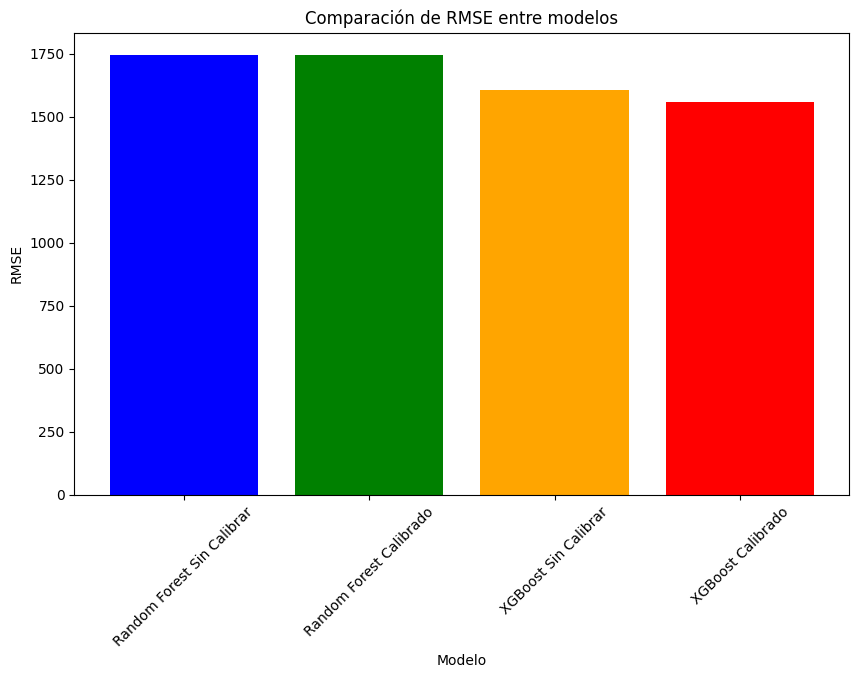

In [ ]:
# Celda 8
models = ['Random Forest Sin Calibrar', 'Random Forest Calibrado', 'XGBoost Sin Calibrar', 'XGBoost Calibrado']

rmse_values = [np.mean(mse_scores_sqrt), min_rmse, rmse_xboost, rmse_calibrado]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange', 'red'])
plt.title('Comparación de RMSE entre modelos')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

Podemos notar que tanto el modelo de Random Forest como el de XGBoost exhiben un RMSE más bajo después de la calibración en comparación con sus versiones sin calibrar. Este hallazgo sugiere una mejora en el rendimiento de ambos modelos gracias a la calibración. En cuanto a sus características distintivas, el Random Forest se destaca por su robustez frente al sobreajuste, lo que lo hace adecuado para conjuntos de datos grandes y complejos. Sin embargo, su desventaja radica en su menor capacidad para manejar conjuntos de datos desbalanceados, lo que puede afectar su interpretación. Por otro lado, XGBoost sobresale en precisión y generalización en una amplia gama de conjuntos de datos, gracias a su flexibilidad y escalabilidad. No obstante, su susceptibilidad al sobreajuste puede ser un punto a tener en cuenta en situaciones de datos ruidosos o de menor tamaño.